# Importing Liabraries

In [1]:
# Importing Required Libraries
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql import *
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import *
from pyspark.sql.functions import udf, log
import pyspark.sql.functions as f
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier

# 1 Data preparation and exploration
## 1.1 Creating Spark Session
### 1.1.1
### 1.1.2

In [2]:
#Creating spark Session using spark context
master = "local[*]"
app_name = 'FIT5202 Assignment-2'
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set('spark.sql.files.maxPartitionBytes',33000000)
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

## 1.2 Loading the data
### 1.2.1

In [3]:
# Defining the schema of memory file according to the meta data and loading the csv
memorySchema = StructType([StructField('ts', IntegerType(), True),
                     StructField('PID', IntegerType(), True),
                     StructField('MINFLT', IntegerType(), True),
                     StructField('MAJFLT', IntegerType(), True),
                     StructField('VSTEXT', IntegerType(), True),
                     StructField('VSIZE', IntegerType(), True),
                     StructField('RSIZE', IntegerType(), True),
                     StructField('VGROW', IntegerType(), True),
                     StructField('RGROW', IntegerType(), True),
                     StructField('MEM', IntegerType(), True),
                     StructField('CMD', StringType(), True),
                     StructField('attack', IntegerType(), True),
                     StructField('type', StringType(), True)])
memoryFile=['linux_memory_1.csv','linux_memory_2.csv']
memoryDf = spark.read.format('csv')\
            .option('header',True)\
            .load(memoryFile,schema=memorySchema,inferSchema =False)

In [4]:
print(memoryDf.count())

2000000


In [5]:
memoryDf.cache()

DataFrame[ts: int, PID: int, MINFLT: int, MAJFLT: int, VSTEXT: int, VSIZE: int, RSIZE: int, VGROW: int, RGROW: int, MEM: int, CMD: string, attack: int, type: string]

In [6]:
# Defining the schema of process file according to the meta data and loading the csv
processSchema = StructType([StructField('ts', IntegerType(), True),
                     StructField('PID', IntegerType(), True),
                     StructField('TRUN', IntegerType(), True),
                     StructField('TSLPI', IntegerType(), True),
                     StructField('TSLPU', IntegerType(), True),
                     StructField('POLI', StringType(), True),
                     StructField('NICE', IntegerType(), True),
                     StructField('PRI', IntegerType(), True),
                     StructField('RTPR', IntegerType(), True),
                     StructField('CPUNR', IntegerType(), True),
                     StructField('Status', StringType(), True),
                     StructField('EXC', IntegerType(), True),
                     StructField('State', StringType(), True),
                     StructField('CPU', IntegerType(), True),
                     StructField('CMD', StringType(), True),
                     StructField('attack', IntegerType(), True),
                     StructField('type', StringType(), True)])

processFile=['linux_process_1.csv','linux_process_2.csv']

processDf = spark.read.format('csv')\
            .option('header',True)\
            .load(processFile,schema=processSchema,inferSchema =False)


In [7]:
processDf.count()

1927968

In [8]:
processDf.cache()

DataFrame[ts: int, PID: int, TRUN: int, TSLPI: int, TSLPU: int, POLI: string, NICE: int, PRI: int, RTPR: int, CPUNR: int, Status: string, EXC: int, State: string, CPU: int, CMD: string, attack: int, type: string]

In [9]:
#checking and counting the nulls and non numberic data in numeric columns in process data
processDf.select([count(when(isnan(i) | col(i).isNull(), i)).alias(i) for i in processDf.columns]).show()

+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+------+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|   CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+------+---+------+----+
|  0|  0|   0|    0|    0|   0|   0|  0|   0|    0|     0|  0|    0|512374|  0|     0|   0|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+------+---+------+----+



In [10]:
#checking and counting the nulls and non numberic data in numeric columns in memory data
memoryDf.select([count(when(isnan(i) | col(i).isNull(), i)).alias(i) for i in memoryDf.columns]).show()

+---+---+------+------+------+------+-----+-----+-----+------+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT| VSIZE|RSIZE|VGROW|RGROW|   MEM|CMD|attack|type|
+---+---+------+------+------+------+-----+-----+-----+------+---+------+----+
|  0|  0|  9737|448868| 27907|523958|83545|50912|10294|302276|  0|     0|   0|
+---+---+------+------+------+------+-----+-----+-----+------+---+------+----+



### 1.2.2

In [11]:
# Re-defining schema after checking the type of values in memory schema 
newMemorySchema = StructType([StructField('ts', IntegerType(), True),
                     StructField('PID', IntegerType(), True),
                     StructField('MINFLT', StringType(), True),
                     StructField('MAJFLT', StringType(), True),
                     StructField('VSTEXT', StringType(), True),
                     StructField('VSIZE', FloatType(), True),
                     StructField('RSIZE', StringType(), True),
                     StructField('VGROW', StringType(), True),
                     StructField('RGROW', StringType(), True),
                     StructField('MEM', FloatType(), True),
                     StructField('CMD', StringType(), True),
                     StructField('attack', IntegerType(), True),
                     StructField('type', StringType(), True)])
memoryFile=['linux_memory_1.csv','linux_memory_2.csv']
newMemoryDf = spark.read.format('csv')\
            .option('header',True)\
            .load(memoryFile,schema=newMemorySchema,inferSchema =False)


In [12]:
processDf.count()

1927968

In [13]:
# Re-defining schema after checking the type of values in process schema
newProcessSchema = StructType([StructField('ts', IntegerType(), True),
                     StructField('PID', IntegerType(), True),
                     StructField('TRUN', IntegerType(), True),
                     StructField('TSLPI', IntegerType(), True),
                     StructField('TSLPU', IntegerType(), True),
                     StructField('POLI', StringType(), True),
                     StructField('NICE', IntegerType(), True),
                     StructField('PRI', IntegerType(), True),
                     StructField('RTPR', IntegerType(), True),
                     StructField('CPUNR', IntegerType(), True),
                     StructField('Status', StringType(), True),
                     StructField('EXC', IntegerType(), True),
                     StructField('State', StringType(), True),
                     StructField('CPU', FloatType(), True),
                     StructField('CMD', StringType(), True),
                     StructField('attack', IntegerType(), True),
                     StructField('type', StringType(), True)])

processFile=['linux_process_1.csv','linux_process_2.csv']
newProcessDf = spark.read.format('csv')\
            .option('header',True)\
            .load(processFile,schema=newProcessSchema,inferSchema =False)


In [14]:
newProcessDf.count()

1927968

In [15]:
# re checking nulls and not a number in process data
newProcessDf.select([count(when(isnan(i) | col(i).isNull(), i)).alias(i) for i in newProcessDf.columns]).show()

+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
|  0|  0|   0|    0|    0|   0|   0|  0|   0|    0|     0|  0|    0|  0|  0|     0|   0|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+



In [16]:
# re checking nulls and not a number in memory data
newMemoryDf.select([count(when(isnan(i) | col(i).isNull(), i)).alias(i) for i in newMemoryDf.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



# Transformation of column into proper formats

In [17]:
#MINFLT replace and type change
replaceK = udf(lambda x: float(x.replace("K", ""))*1000 if "K" in x else float(x), FloatType())
newMemoryDf = newMemoryDf.withColumn("MINFLT", replaceK("MINFLT"))
newMemoryDf.show(5)

+----------+----+--------+------+------+-----+-----+-----+-----+----+--------------+------+------+
|        ts| PID|  MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW| MEM|           CMD|attack|  type|
+----------+----+--------+------+------+-----+-----+-----+-----+----+--------------+------+------+
|1554218915|3257|859502.0|    54|   193|  2.0|519.1|    2|519.1|0.14|   Web-Content|     0|normal|
|1554218920|3197|247354.0|    95|   193|  2.6|  402|  2.6|  402|0.11|       firefox|     0|normal|
|1554218925|1442| 57311.0|    33|  2219|764.2|290.7|764.2|290.7|0.08|          Xorg|     0|normal|
|1554218930|3119| 68006.0|    17|  3063|725.9|116.8|725.9|116.8|0.03|update-manager|     0|normal|
|1554218935|2797| 72300.0|    69|  1350|  1.4|109.6|  1.4|109.6|0.03|      nautilus|     0|normal|
+----------+----+--------+------+------+-----+-----+-----+-----+----+--------------+------+------+
only showing top 5 rows



In [18]:
#MAJFLT replace and type change
replaceM = udf(lambda x: float(x.replace("M", ""))*1000000 if "M" in x else float(x), FloatType())
newMemoryDf = newMemoryDf.withColumn("MAJFLT", replaceM("MAJFLT"))
newMemoryDf.show(5)

+----------+----+--------+------+------+-----+-----+-----+-----+----+--------------+------+------+
|        ts| PID|  MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW| MEM|           CMD|attack|  type|
+----------+----+--------+------+------+-----+-----+-----+-----+----+--------------+------+------+
|1554218915|3257|859502.0|  54.0|   193|  2.0|519.1|    2|519.1|0.14|   Web-Content|     0|normal|
|1554218920|3197|247354.0|  95.0|   193|  2.6|  402|  2.6|  402|0.11|       firefox|     0|normal|
|1554218925|1442| 57311.0|  33.0|  2219|764.2|290.7|764.2|290.7|0.08|          Xorg|     0|normal|
|1554218930|3119| 68006.0|  17.0|  3063|725.9|116.8|725.9|116.8|0.03|update-manager|     0|normal|
|1554218935|2797| 72300.0|  69.0|  1350|  1.4|109.6|  1.4|109.6|0.03|      nautilus|     0|normal|
+----------+----+--------+------+------+-----+-----+-----+-----+----+--------------+------+------+
only showing top 5 rows



In [19]:
#VSTEXT replace and type change
replaceK = udf(lambda x: float(x.replace("K", ""))*1000 if "K" in x else float(x), FloatType())
newMemoryDf= newMemoryDf.withColumn("VSTEXT", replaceK("VSTEXT"))
newMemoryDf.show(5)

+----------+----+--------+------+------+-----+-----+-----+-----+----+--------------+------+------+
|        ts| PID|  MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW| MEM|           CMD|attack|  type|
+----------+----+--------+------+------+-----+-----+-----+-----+----+--------------+------+------+
|1554218915|3257|859502.0|  54.0| 193.0|  2.0|519.1|    2|519.1|0.14|   Web-Content|     0|normal|
|1554218920|3197|247354.0|  95.0| 193.0|  2.6|  402|  2.6|  402|0.11|       firefox|     0|normal|
|1554218925|1442| 57311.0|  33.0|2219.0|764.2|290.7|764.2|290.7|0.08|          Xorg|     0|normal|
|1554218930|3119| 68006.0|  17.0|3063.0|725.9|116.8|725.9|116.8|0.03|update-manager|     0|normal|
|1554218935|2797| 72300.0|  69.0|1350.0|  1.4|109.6|  1.4|109.6|0.03|      nautilus|     0|normal|
+----------+----+--------+------+------+-----+-----+-----+-----+----+--------------+------+------+
only showing top 5 rows



In [20]:
#RSIZE replace and type change
replaceM = udf(lambda x: str(float(x.replace("M", ""))*1000000) if "M" in x else x, StringType())
newMemoryDf = newMemoryDf.withColumn("RSIZE", replaceM("RSIZE"))

replaceK = udf(lambda y: str(float(y.replace("K", ""))*1000) if "K" in y else y, StringType())
newMemoryDf = newMemoryDf.withColumn("RSIZE", replaceK("RSIZE"))

newMemoryDf = newMemoryDf.withColumn("RSIZE", newMemoryDf["RSIZE"].cast(FloatType()))
newMemoryDf.show(5)

+----------+----+--------+------+------+-----+-----+-----+-----+----+--------------+------+------+
|        ts| PID|  MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW| MEM|           CMD|attack|  type|
+----------+----+--------+------+------+-----+-----+-----+-----+----+--------------+------+------+
|1554218915|3257|859502.0|  54.0| 193.0|  2.0|519.1|    2|519.1|0.14|   Web-Content|     0|normal|
|1554218920|3197|247354.0|  95.0| 193.0|  2.6|402.0|  2.6|  402|0.11|       firefox|     0|normal|
|1554218925|1442| 57311.0|  33.0|2219.0|764.2|290.7|764.2|290.7|0.08|          Xorg|     0|normal|
|1554218930|3119| 68006.0|  17.0|3063.0|725.9|116.8|725.9|116.8|0.03|update-manager|     0|normal|
|1554218935|2797| 72300.0|  69.0|1350.0|  1.4|109.6|  1.4|109.6|0.03|      nautilus|     0|normal|
+----------+----+--------+------+------+-----+-----+-----+-----+----+--------------+------+------+
only showing top 5 rows



In [21]:
#VGROW replace and type change
replaceSPC = udf(lambda x: str(float(x.replace(" ", ""))) if " " in x else x, StringType())
newMemoryDf = newMemoryDf.withColumn("VGROW", replaceSPC("VGROW"))

replaceK = udf(lambda y: str(float(y.replace("K", ""))*1000) if "K" in y else y, StringType())
newMemoryDf = newMemoryDf.withColumn("VGROW", replaceK("VGROW"))

newMemoryDf = newMemoryDf.withColumn("VGROW", newMemoryDf["VGROW"].cast(FloatType()))
newMemoryDf.show(5)

+----------+----+--------+------+------+-----+-----+-----+-----+----+--------------+------+------+
|        ts| PID|  MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW| MEM|           CMD|attack|  type|
+----------+----+--------+------+------+-----+-----+-----+-----+----+--------------+------+------+
|1554218915|3257|859502.0|  54.0| 193.0|  2.0|519.1|  2.0|519.1|0.14|   Web-Content|     0|normal|
|1554218920|3197|247354.0|  95.0| 193.0|  2.6|402.0|  2.6|  402|0.11|       firefox|     0|normal|
|1554218925|1442| 57311.0|  33.0|2219.0|764.2|290.7|764.2|290.7|0.08|          Xorg|     0|normal|
|1554218930|3119| 68006.0|  17.0|3063.0|725.9|116.8|725.9|116.8|0.03|update-manager|     0|normal|
|1554218935|2797| 72300.0|  69.0|1350.0|  1.4|109.6|  1.4|109.6|0.03|      nautilus|     0|normal|
+----------+----+--------+------+------+-----+-----+-----+-----+----+--------------+------+------+
only showing top 5 rows



In [22]:
#RGROW replace and type change
replaceK = udf(lambda x: float(x.replace("K", ""))*1000 if "K" in x else float(x), FloatType())
newMemoryDf = newMemoryDf.withColumn("RGROW", replaceK("RGROW"))
newMemoryDf.show(5)

+----------+----+--------+------+------+-----+-----+-----+-----+----+--------------+------+------+
|        ts| PID|  MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW| MEM|           CMD|attack|  type|
+----------+----+--------+------+------+-----+-----+-----+-----+----+--------------+------+------+
|1554218915|3257|859502.0|  54.0| 193.0|  2.0|519.1|  2.0|519.1|0.14|   Web-Content|     0|normal|
|1554218920|3197|247354.0|  95.0| 193.0|  2.6|402.0|  2.6|402.0|0.11|       firefox|     0|normal|
|1554218925|1442| 57311.0|  33.0|2219.0|764.2|290.7|764.2|290.7|0.08|          Xorg|     0|normal|
|1554218930|3119| 68006.0|  17.0|3063.0|725.9|116.8|725.9|116.8|0.03|update-manager|     0|normal|
|1554218935|2797| 72300.0|  69.0|1350.0|  1.4|109.6|  1.4|109.6|0.03|      nautilus|     0|normal|
+----------+----+--------+------+------+-----+-----+-----+-----+----+--------------+------+------+
only showing top 5 rows



## 1.3
### 1.3.1

In [23]:
# grouping and returning count of the attack or non attack in attack column in memory data
memoryAttackCount = newMemoryDf.groupby(newMemoryDf['attack'])\
        .agg(f.count(newMemoryDf['attack']).alias('attack Count')).show()

+------+------------+
|attack|attack Count|
+------+------------+
|     1|      205623|
|     0|     1794377|
+------+------------+



In [24]:
# grouping and returning count of the attack or non attack in attack column in process data
processAttackCount = newProcessDf.groupby(newProcessDf['attack'])\
                    .agg(f.count(newProcessDf['attack']).alias('attack Count')).show()

+------+------------+
|attack|attack Count|
+------+------------+
|     1|      291364|
|     0|     1636604|
+------+------------+



In [25]:
# counting and grouping od types of attack in memory
memoryAttackTypeCount = newMemoryDf.groupby(newMemoryDf['type']).agg(f.count(newMemoryDf['type'])\
                                                                     .alias('attack types')).show()

+---------+------------+
|     type|attack types|
+---------+------------+
| password|       26016|
|     ddos|       45689|
|   normal|     1794377|
|     mitm|         112|
|injection|       58523|
|      dos|       75283|
+---------+------------+



In [26]:
# counting and grouping od types of attack in process
processAttackTypeCount = newProcessDf.groupby(newProcessDf['type'])\
                        .agg(f.count(newProcessDf['type']).alias('attack types')).show()

+---------+------------+
|     type|attack types|
+---------+------------+
|      xss|       17759|
| password|       51409|
| scanning|       38449|
|     ddos|       71603|
|   normal|     1636604|
|     mitm|         112|
|injection|       41311|
|      dos|       70721|
+---------+------------+



### 1.3.2

In [27]:
memoryDf.select('ts').summary("count", "mean","stddev","min", "max" ).show()
memoryDf.select('PID').summary("count", "mean","stddev","min", "max" ).show()
memoryDf.select('MINFLT').summary("count", "mean","stddev","min", "max" ).show()
memoryDf.select('MAJFLT').summary("count", "mean","stddev","min", "max" ).show()
memoryDf.select('VSTEXT').summary("count", "mean","stddev","min", "max" ).show()
memoryDf.select('VSIZE').summary("count", "mean","stddev","min", "max" ).show()
memoryDf.select('RSIZE').summary("count", "mean","stddev","min", "max" ).show()
memoryDf.select('VGROW').summary("count", "mean","stddev","min", "max" ).show()
memoryDf.select('RGROW').summary("count", "mean","stddev","min", "max" ).show()
memoryDf.select('MEM').summary("count", "mean","stddev","min", "max" ).show()
memoryDf.select('attack').summary("count", "mean","stddev","min", "max" ).show()

+-------+------------------+
|summary|                ts|
+-------+------------------+
|  count|           2000000|
|   mean|1.55624581707609E9|
| stddev| 984463.3683082614|
|    min|        1554216855|
|    max|        1558355716|
+-------+------------------+

+-------+-----------------+
|summary|              PID|
+-------+-----------------+
|  count|          2000000|
|   mean|      4999.360446|
| stddev|4887.313351921488|
|    min|             1007|
|    max|            53096|
+-------+-----------------+

+-------+------------------+
|summary|            MINFLT|
+-------+------------------+
|  count|           1990263|
|   mean|404.51371904115183|
| stddev| 17185.87691600473|
|    min|                 0|
|    max|           8050000|
+-------+------------------+

+-------+------------------+
|summary|            MAJFLT|
+-------+------------------+
|  count|           1551132|
|   mean|1336.2793443755916|
| stddev| 5856.323936313231|
|    min|                 0|
|    max|           

In [28]:
memoryDf.groupby('CMD').agg(f.count('CMD').alias('Count')).sort('Count', ascending = False).show(10)
memoryDf.groupby('type').agg(f.count('type').alias('Count')).sort('Count', ascending = False).show(10)

+----------+------+
|       CMD| Count|
+----------+------+
|      atop|325985|
|   apache2| 89761|
| jfsCommit| 81714|
|  vmtoolsd| 77871|
|      Xorg| 49981|
|  nautilus| 48356|
|irqbalance| 44387|
|    compiz| 44356|
|  ostinato| 43024|
|     drone| 41392|
+----------+------+
only showing top 10 rows

+---------+-------+
|     type|  Count|
+---------+-------+
|   normal|1794377|
|      dos|  75283|
|injection|  58523|
|     ddos|  45689|
| password|  26016|
|     mitm|    112|
+---------+-------+



In [30]:
processDf.select('ts').summary("count", "mean","stddev","min", "max" ).show()
processDf.select('PID').summary("count", "mean","stddev","min", "max" ).show()
processDf.select('TRUN').summary("count", "mean","stddev","min", "max" ).show()
processDf.select('TSLPI').summary("count", "mean","stddev","min", "max" ).show()
processDf.select('TSLPU').summary("count", "mean","stddev","min", "max" ).show()
processDf.select('NICE').summary("count", "mean","stddev","min", "max" ).show()
processDf.select('PRI').summary("count", "mean","stddev","min", "max" ).show()
processDf.select('RTPR').summary("count", "mean","stddev","min", "max" ).show()
processDf.select('CPUNR').summary("count", "mean","stddev","min", "max" ).show()
processDf.select('EXC').summary("count", "mean","stddev","min", "max" ).show()
processDf.select('CPU').summary("count", "mean","stddev","min", "max" ).show()
processDf.select('attack').summary("count", "mean","stddev","min", "max" ).show()

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|             1927968|
|   mean|1.5563198311840394E9|
| stddev|   771350.0247950464|
|    min|          1554216855|
|    max|          1557593017|
+-------+--------------------+

+-------+-----------------+
|summary|              PID|
+-------+-----------------+
|  count|          1927968|
|   mean|5068.709770597852|
| stddev|4987.784329320435|
|    min|             1007|
|    max|            53080|
+-------+-----------------+

+-------+------------------+
|summary|              TRUN|
+-------+------------------+
|  count|           1927968|
|   mean|0.0632287465352122|
| stddev|0.2478258709041604|
|    min|                 0|
|    max|                12|
+-------+------------------+

+-------+-----------------+
|summary|            TSLPI|
+-------+-----------------+
|  count|          1927968|
|   mean|3.508334163222626|
| stddev|6.988459728531843|
|    min|                0|
|    max|

In [29]:
processDf.groupby('POLI').agg(f.count('POLI').alias('Count')).sort('Count', ascending = False).show(10)
processDf.groupby('Status').agg(f.count('Status').alias('Count')).sort('Count', ascending = False).show(10)
processDf.groupby('CMD').agg(f.count('CMD').alias('Count')).sort('Count', ascending = False).show(10)
processDf.groupby('type').agg(f.count('type').alias('Count')).sort('Count', ascending = False).show(10)

+----+-------+
|POLI|  Count|
+----+-------+
|norm|1861558|
|   0|  53216|
|   -|  13194|
+----+-------+

+------+-------+
|Status|  Count|
+------+-------+
|     -|1416322|
|     0| 438984|
|    NE|  48602|
|     N|  23313|
|    NS|    743|
|     C|      3|
|    NC|      1|
+------+-------+

+--------------+------+
|           CMD| Count|
+--------------+------+
|          atop|441180|
|       apache2|313143|
|      vmtoolsd|112029|
|          Xorg| 66813|
|      nautilus| 63449|
|gnome-terminal| 47628|
|        compiz| 44386|
|    irqbalance| 44324|
|      ostinato| 42979|
|         drone| 41390|
+--------------+------+
only showing top 10 rows

+---------+-------+
|     type|  Count|
+---------+-------+
|   normal|1636604|
|     ddos|  71603|
|      dos|  70721|
| password|  51409|
|injection|  41311|
| scanning|  38449|
|      xss|  17759|
|     mitm|    112|
+---------+-------+



# 1.3 class Imbalance:

In the above part we have found out the count of attack and non attack values in attack column and type column in both the dataframes i.e process, memory. Looking at the count of attack in memory dataframe 205623 are the cases where there was an attack and 1794377 where cases where no attack was found as we can see there is a huge difference between both the cases this will imbalance the training and testing dataset as data would not be able to classify between the class as there are so many cases of non attack events that and the model would not be able to predict with a good accuracy as data is bit biased and would only have majority of share as non attack events. 

Similar is the case with process dataframe where there are 291364 entries of attack event and 1636604 entries of non-attack events. This will lead to similar type of issue where the model would not be able to predict the model fairly. This is due to class imbalance and is faced in many model.


Thus accuracy is affected by the imbanced ratio within the data and affects the model. Due to this the model while not be able to train to predict the accuracy.

# 1.3.3

In [30]:
import pandas as pd
import numpy as np
from pyspark.sql.functions import *

memdfplot = newMemoryDf.orderBy(rand()).limit(200000)
memdfplot1 = memdfplot.toPandas()
corr = memdfplot1.corr()
corr.style.background_gradient(cmap='Greens').set_precision(2)

,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,attack
ts,1.00,-0.53,-0.00,-0.00,0.00,-0.09,-0.00,0.00,0.32,0.03,0.04
PID,-0.53,1.00,0.07,0.16,0.16,-0.14,0.01,0.01,-0.18,-0.12,-0.10
MINFLT,-0.00,0.07,1.00,0.45,0.45,0.01,0.05,0.06,-0.00,-0.01,0.09
MAJFLT,-0.00,0.16,0.45,1.00,1.00,-0.03,0.11,0.13,-0.02,-0.02,0.19
VSTEXT,0.00,0.16,0.45,1.00,1.00,-0.04,0.11,0.13,-0.02,-0.02,0.19
VSIZE,-0.09,-0.14,0.01,-0.03,-0.04,1.00,-0.00,0.01,-0.14,-0.14,-0.00
RSIZE,-0.00,0.01,0.05,0.11,0.11,-0.00,1.00,0.98,-0.00,0.00,0.02
VGROW,0.00,0.01,0.06,0.13,0.13,0.01,0.98,1.00,-0.00,0.00,0.03
RGROW,0.32,-0.18,-0.00,-0.02,-0.02,-0.14,-0.00,-0.00,1.00,-0.02,-0.02
MEM,0.03,-0.12,-0.01,-0.02,-0.02,-0.14,0.00,0.00,-0.02,1.00,0.01


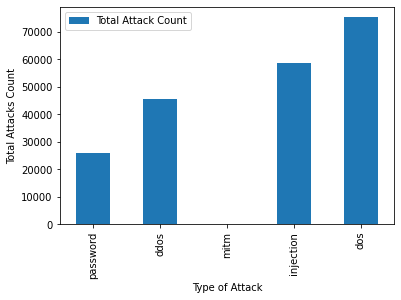

In [31]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
memplot2 = newMemoryDf.filter(newMemoryDf.attack == 1).groupby('type').agg(F.count('attack').alias('Total Attack Count')).toPandas()
     

memplot2.plot.bar(x = 'type') #Plotting bar graph
plt.xlabel('Type of Attack') #defining x label
plt.ylabel('Total Attacks Count') #defining y label
plt.show()

In the above two plots we have plotted for the memory data set there is a correlation matrix and a bar chart that represent the following:

- In Bar plot We have plotted a bar chart that descibes the different type of attack types in the memory data and we can see in the plot that injection and dos has the highest count and mitm has the lowest

- In Correlation Plot: The correlation plot shows the relationship between each feature of the memory data which has integer data type value close to 1 represent highly correlated variables and variable near to -1 represnt less correlated variable 

In [32]:
import pandas as pd
import numpy as np
from pyspark.sql.functions import *

prsfplot = newProcessDf.orderBy(rand()).limit(200000)
prsfplot1 = prsfplot.toPandas()
corr = prsfplot1.corr()
corr.style.background_gradient(cmap='viridis').set_precision(2)

/home/student/.local/lib/python3.8/site-packages/pandas/io/formats/style.py:1089: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/home/student/.local/lib/python3.8/site-packages/pandas/io/formats/style.py:1090: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,ts,PID,TRUN,TSLPI,TSLPU,NICE,PRI,RTPR,CPUNR,EXC,CPU,attack
ts,1.00,0.06,-0.03,0.02,-0.00,-0.05,0.09,nan,0.17,-0.01,-0.06,0.02
PID,0.06,1.00,-0.06,-0.18,-0.00,-0.14,-0.14,nan,0.07,0.01,-0.04,-0.05
TRUN,-0.03,-0.06,1.00,0.01,-0.00,0.23,-0.04,nan,-0.04,-0.01,0.52,-0.01
TSLPI,0.02,-0.18,0.01,1.00,-0.00,-0.21,0.17,nan,0.07,-0.01,0.15,0.05
TSLPU,-0.00,-0.00,-0.00,-0.00,1.00,-0.00,0.00,nan,0.00,-0.00,0.01,-0.00
NICE,-0.05,-0.14,0.23,-0.21,-0.00,1.00,-0.27,nan,-0.08,-0.01,-0.06,-0.07
PRI,0.09,-0.14,-0.04,0.17,0.00,-0.27,1.00,nan,0.26,-0.10,0.05,0.00
RTPR,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
CPUNR,0.17,0.07,-0.04,0.07,0.00,-0.08,0.26,nan,1.00,-0.03,-0.05,0.01
EXC,-0.01,0.01,-0.01,-0.01,-0.00,-0.01,-0.10,nan,-0.03,1.00,-0.00,-0.00


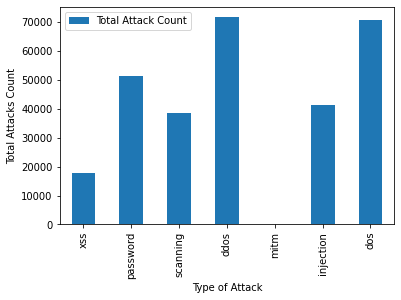

In [33]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
prosplotdf = newProcessDf.filter(newProcessDf.attack == 1).groupby('type').agg(f.count('attack').alias('Total Attack Count')).toPandas()
     

prosplotdf.plot.bar(x = 'type') #Plotting bar graph
plt.xlabel('Type of Attack') #defining x label
plt.ylabel('Total Attacks Count') #defining y label
plt.show()

Now for the process data In the above two plots we have plotted data set there is a correlation matrix and a bar chart that represent the following:

- In Bar plot We have plotted a bar chart that descibes the different type of attack types in the memory data and we can see in the plot that ddos and dos has the highest count and mitm has the lowest

- In Correlation Plot: The correlation plot shows the relationship between each feature of the memory data which has integer data type value close to 1 represent highly correlated variables and variable near to -1 represnt less correlated variable 

# 2 Feature extraction and ML training
## 2.1 Preparing the training data and testing data
### 2.1.1

In [34]:
# creating training and testing data at random for memory data
trainMemory, testMemory = newMemoryDf.randomSplit([0.8, 0.2])

In [35]:
# creating training and testing data at random for process data
trainProcess, testProcess = newProcessDf.randomSplit([0.8, 0.2])

## 2.1.2

In [36]:
MemoryTrainAttackCount=0
MemoryTrain_NAttackCount=0
MemoryTrain_Attack=trainMemory.filter((trainMemory['attack']==1))
MemoryTrain_nAttack= trainMemory.filter((trainMemory['attack']==0))
MemoryTrainAttackCount=(int) (MemoryTrain_Attack.count()*0.2)
MemoryTrain_NAttackCount=(int) (MemoryTrainAttackCount*2)
train_memory_Attack=MemoryTrain_Attack.orderBy(f.rand()).limit(MemoryTrainAttackCount)
train_memory_nAttack=MemoryTrain_nAttack.orderBy(f.rand()).limit(MemoryTrain_NAttackCount)
final_train_memory=train_memory_Attack.union(train_memory_nAttack)

In [37]:
processTrainAttackCount=0
processTrain_NAttackCount=0
processTrain_Attack=trainProcess.filter((trainProcess['attack']==1))
processTrain_nAttack= trainProcess.filter((trainProcess['attack']==0))
processTrainAttackCount=(int) (processTrain_Attack.count()*0.2)
processTrain_NAttackCount=(int) (processTrainAttackCount*2)
train_process_Attack=processTrain_Attack.orderBy(f.rand()).limit(processTrainAttackCount)
train_process_nAttack=processTrain_nAttack.orderBy(f.rand()).limit(processTrain_NAttackCount)
final_train_process=train_process_Attack.union(train_process_nAttack)

# 2.2.1 Feature selection

In [38]:
featuresMemory= ['MINFLT','VSTEXT','VSIZE','RGROW','VGROW','RSIZE']

In [39]:
featuresProcess = ['TSLPI','NICE','PRI']

In order to select the features two factors i.e variance of the input column as we know that when variance is around 0 i.e. less deviation leads to an indication that the input columns is constant and there is considerablely no chance of improvement in the perfomance of the model. A threshold is set for variance using the probablity distribution function to select the most appropriate input variable for the model and other factor that is considered is the fact that the correlation between input and output column where the outout columns is the 'attack' column.

So in the data that we are provided we will consider those features the have comparitively high variance and those that have less variance will not be considered as the are not very usefull for out model

Now while looking at the correlation factor we know features that have high correlation value are more related to the output class as they are linearly dependent on each other and have effect on each other as depenent variable.

After understanding the two factors we can now narrow down our feature list to MINFLT, VSTEXT, VSIZE, RGROW, VGROW and SIZE for the memory data and for process we can select TSLPI, POLI, NICE and PRI

In memory Data mostly all the input variable are in numeric format thus we can directly pass it to the standard scaler as the column with high difference will normalise them in equal proportion and the output passed to vector assembler will concatenate all the feature in a column thus we can pass both the decision tree and gradient booster tree model on the feature.


For the process data set POLI column is in string thus we will use string indexer before passing to one hot encoder along with TSLPI, POLI and PRI to convert integer to byte and we will pass it to vector assembler and finally to decision tree and gradient boosted tree model.


## 2.2.2

In [40]:
# Memory feature, assembler and scaler 

assemblerMemory = VectorAssembler(inputCols=featuresMemory, outputCol='featureUsed')
scalerMemory = StandardScaler(inputCol='featureUsed', outputCol='scaledFeature')


In [41]:

inputIndexer=['POLI']
outputIndexer=['POLI_index']
outputEncoder=['POLI_vec']
indexer = StringIndexer(inputCols=inputIndexer,outputCols=outputIndexer)


In [42]:
encoder = OneHotEncoder(inputCols=outputIndexer,outputCols=outputEncoder)
featuresProcess=featuresProcess+outputEncoder
print(featuresProcess)
process_assembler = VectorAssembler(inputCols=featuresProcess,outputCol='features')

feature_predicted_Dtree = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'attack', maxDepth = 3)

['TSLPI', 'NICE', 'PRI', 'POLI_vec']


## 2.2.3

In [43]:
memory_Dtree = DecisionTreeClassifier(featuresCol = 'scaledFeature', labelCol = 'attack', maxDepth = 3)
memory_pipeline_Dtree= Pipeline(stages=[assemblerMemory,scalerMemory,memory_Dtree])


In [44]:
from pyspark.ml import Pipeline

process_pipeline_Dtree = Pipeline(stages=[indexer,encoder,process_assembler,feature_predicted_Dtree])



In [45]:
from pyspark.ml.classification import GBTClassifier


gbtClassify = GBTClassifier(labelCol="attack", featuresCol="scaledFeature", maxIter=10)
from pyspark.ml import Pipeline
memoryGDT_pipeline = Pipeline(stages=[assemblerMemory,scalerMemory,gbtClassify])



In [46]:
# process GDT
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline

gbtClassify_process = GBTClassifier(labelCol="attack", featuresCol="features", maxIter=10)

processGDT_pipeline = Pipeline(stages=[indexer,encoder,process_assembler,gbtClassify_process])





# 2.3.1

In [47]:
memory_Dtree_model = memory_pipeline_Dtree.fit(final_train_memory)
model_process_decisiontree = process_pipeline_Dtree.fit(final_train_process)
memory_GDT_model = memoryGDT_pipeline.fit(final_train_memory)
process_GDT_model = processGDT_pipeline.fit(final_train_process)

PipelineModel_e526c20dc66a

## 2.3.2 & 2.3.3

In [48]:
memory_predicted_Dtree = memory_Dtree_model.transform(testMemory)
process_gdt_predict = process_GDT_model.transform(testProcess)
memory_gdt_predict = memory_GDT_model.transform(testMemory)
process_Dtree_predict = model_process_decisiontree.transform(testProcess)


In [49]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
def compute_metrics(prediction):
    TN = prediction.filter('prediction = 0 AND attack = 0').count()
    TP = prediction.filter('prediction = 1 AND attack = 1').count()
    FN = prediction.filter('prediction = 0 AND attack = 1').count()
    FP = prediction.filter('prediction = 1 AND attack = 0').count()
    accuracy = (TP + TN)/(TP + TN + FP + FN)#WRITE CODE : formula to find accuracy
    precision = TP / (TP + FP)#WRITE CODE : formula to find precision
    recall = TP / (TP + FN)#WRITE CODE : formula to find recall
    evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol="attack")
    auc_dt = evaluator.evaluate(prediction)
    return auc_dt,accuracy,precision,recall

In [50]:
decision_metric_memory = compute_metrics(memory_predicted_Dtree)
print("Decision Tree for Memory dataset")
print("\nArea Under Curve :", decision_metric_memory[0])
print("\nAccuracy :", decision_metric_memory[1])
print("\nPrecision :", decision_metric_memory[2])
print("\nRecall :", decision_metric_memory[3])

gradient_metric_memory = compute_metrics(memory_gdt_predict)
print("\nGraident Tree for Memory dataset ")
print("\nArea Under Curve :", gradient_metric_memory[0])
print("\nAccuracy :", gradient_metric_memory[1])
print("\nPrecision :", gradient_metric_memory[2])
print("\nRecall :", gradient_metric_memory[3])

Decision Tree for Memory dataset

Area Under Curve : 0.4029571315348834

Accuracy : 0.8082693806583129

Precision : 0.22699041805232867

Recall : 0.3664444008629143

Graident Tree for Memory dataset 

Area Under Curve : 0.8070249398389373

Accuracy : 0.8632886663868737

Precision : 0.3583382475547512

Recall : 0.43199646989605806


In [51]:
try:
    decision_metric_process = compute_metrics(process_Dtree_predict)
    print("Decision Tree for Process dataset")
    print("\nArea Under Curve :", decision_metric_process[0])
    print("\nAccuracy :", decision_metric_process[1])
    print("\nPrecision :", decision_metric_process[2])
    print("\nRecall :", decision_metric_process[3])

except:
    pass
gradient_metric_process = compute_metrics(process_gdt_predict)
print("\nGraident Tree for Memory dataset ")
print("\nArea Under Curve :", gradient_metric_process[0])
print("\nAccuracy :", gradient_metric_process[1])
print("\nPrecision :", gradient_metric_process[2])
print("\nRecall :", gradient_metric_process[3])




Decision Tree for Process dataset

Area Under Curve : 0.5227969895352536

Accuracy : 0.8356996340985885

Precision : 0.2650306748466258

Recall : 0.04809948782952774

Graident Tree for Memory dataset 

Area Under Curve : 0.5892252829330865

Accuracy : 0.8360860218399836

Precision : 0.2973993288590604

Recall : 0.0607238904400555


# AUC & ACC & precision and recall which is better

The Most important metric in identifying the best model is AUC at different threshold. AUC represents the degree or measure of separabilty i.e the measure of seperablity i.e how much the model can differentiate between groups.
AUC will be higher when the model is able to predict attack and non attack as the same i.e attack or non attack. In this assignment we used binaryClassificationEvaluator for computing the AUC-ROC curve. when we see that AUC values for both the algo in the data sets we see GBT algorithm has a higher AUC and accuracy as well.

# 2.3.4
## Memory Data

In [52]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def init(self, *args):
        super(CurveMetrics, self).init(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

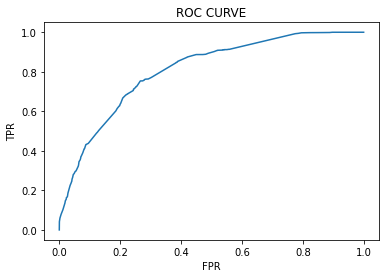

In [55]:
import matplotlib.pyplot as plt

preds = memory_gdt_predict.select('attack','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['attack'])))

# Returns as a list (false positive rate, true positive rate)
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title("ROC CURVE")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(x_val, y_val)

## Process data

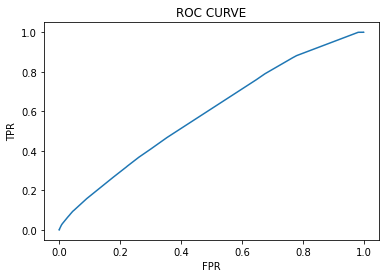

In [56]:
import matplotlib.pyplot as plt

preds = process_gdt_predict.select('attack','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['attack'])))

# Returns as a list (false positive rate, true positive rate)
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title("ROC CURVE")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(x_val, y_val)

In [61]:
memory_Dtree_model.stages[-1].featureImportances

SparseVector(6, {0: 0.3419, 1: 0.0769, 2: 0.2116, 5: 0.3695})

The top 5 features according to the values in memory gradient tree are:

- VSTEXT
- RSIZE
- VSIZE
- MINFLT
- RGROW

The sparse vector shows the index and the score so that we can grade which features are important.

In [62]:
memory_GDT_model.stages[-1].featureImportances

SparseVector(6, {0: 0.2918, 1: 0.1633, 2: 0.1542, 3: 0.0171, 4: 0.0111, 5: 0.3625})

The top 5 features according to the values in memory decision tree are

- VSTEXT
- RSIZE
- VSIZE
- MINFLT
- RGROW

The sparse vector shows the index and the score so that we can grade which features are important.

In [63]:
model_process_decisiontree.stages[-1].featureImportances

SparseVector(5, {0: 0.3099, 1: 0.6901})

The top 5 features according to the values in processs decision tree are

- TSLPI
- NICE

The sparse vector shows the index and the score so that we can grade which features are important.

In [64]:
process_GDT_model.stages[-1].featureImportances

SparseVector(5, {0: 0.8989, 1: 0.0733, 2: 0.0108, 4: 0.0169})

The top 5 features according to the values in memory decision tree are

- TSLPI
- NICE
- PRI
- POLI

The sparse vector shows the index and the score so that we can grade which features are important.

# 2.3.5

In [65]:
train_memory_1_new = newMemoryDf.filter(col("attack") == 1)
countNew1 = train_memory_1_new.count()
countNew0 = 2 * countNew1
train_memory_0 = newMemoryDf.filter(col("attack") == 0)
train_memory_0_new = train_memory_0.orderBy(f.rand()).limit(countNew0)

411246

In [66]:
train_memory_merged = train_memory_0_new.union(train_memory_1_new)
train_memory_merged.count()
memory_gt = memoryGDT_pipeline.fit(train_memory_merged)

In [67]:
train_process_1_new = newProcessDf.filter(col("attack") == 1)
countNew1 = train_process_1_new.count()
countNew0 = 2 * countNew1
train_process_0 = newProcessDf.filter(col("attack") == 0)
train_process_0_new = train_process_0.orderBy(f.rand()).limit(countNew0)
train_process_0_new.count()

train_process_merged = train_process_0_new.union(train_process_1_new)
train_process_merged.count()
process_gt = processGDT_pipeline.fit(train_process_merged)

# 3 Knowledge sharing
## 3.1

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

iris_df = spark.createDataFrame([
(4.7, 3.2, 1.3, 0.2),
(4.9, 3.1, 1.5, 0.1),
(5.4, 3.9, 1.3, 0.4),
(5.0, 3.4, 1.6, 0.4),
(5.1, 3.8, 1.6, 0.2),
(4.9, 2.4, 3.3, 1.0),
(6.6, 2.9, 4.6, 1.3),
(5.6, 3.0, 4.5, 1.5),
(5.7, 2.6, 3.5, 1.0),
(5.8, 2.6, 4.0, 1.2),
(5.8, 2.8, 5.1, 2.4),
(6.2, 2.8, 4.8, 1.8),
(6.0, 3.0, 4.8, 1.8),
(6.7, 3.1, 5.6, 2.4),
(6.7, 3.0, 5.2, 2.3),
(6.2, 3.4, 5.4, 2.3)],
['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])


assembler = VectorAssembler(
inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
outputCol='features')
kmeans = KMeans(k=3).fit(assembler.transform(iris_df))

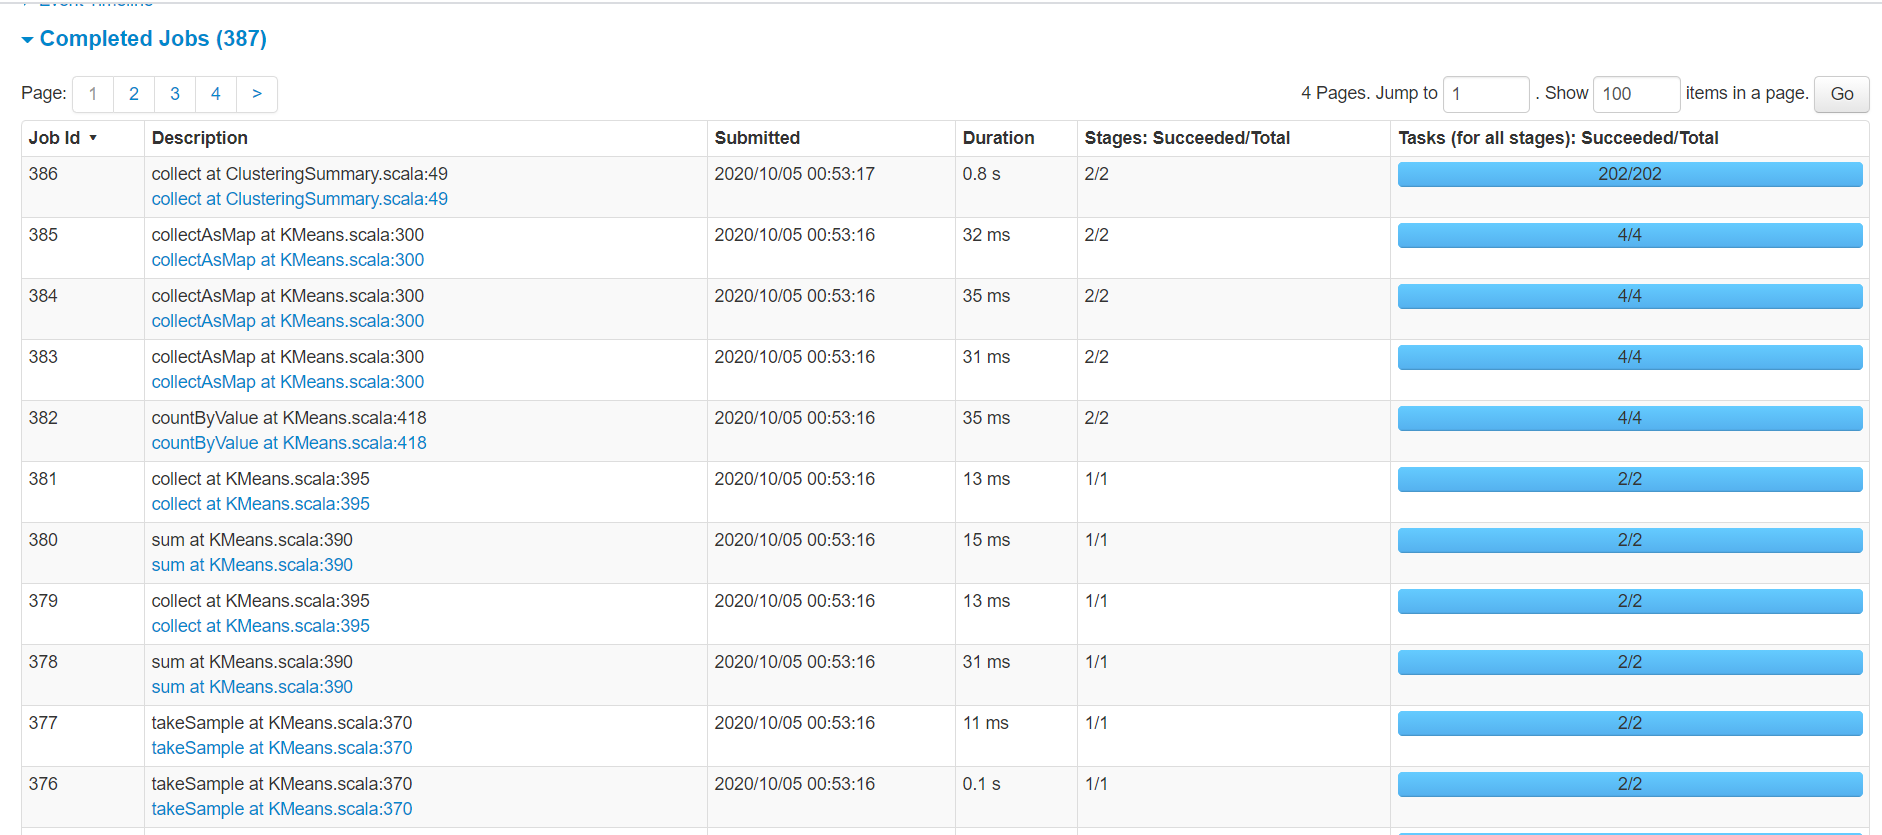

## Total of 10 Jobs are running in the K-means Model

# 3.2

Looking at the Spark UI we can see that spark UI uses parrallalism to process the KMeans model where data is partitioned as per the number of avaiable processors. Following that clusers od data are build in each processors and mean of each cluster is calculated and data close to the cluster mean is circulated in those clusters based on the distance from the centroid of the cluster i.e. the mean. When all the values are passed to the correct cluster then the processing stops and this clustering of data is called as K means algorithm.

In Spark UI there are 10 jobs running as supported in the above screen shot.
what the take sample job does is it divides all the data into different clusters and then at each cluster the mean is calculated these mean keep on changing as dependending on the values that are in there and once all the values whichb are related the mean changes at a slow rate and then fixes itself. The mean is evaluated at the sum job in kMeans and then those value points are transfered which are not close to the mean as they do not belong to the cluster. Following that the collect job is just collecting the data in each cluster and the count by value job is counting the number of clusters which are formed . So when all of this is done the collectAsMap collects the data from all the final clusters and from the processes and then the collected at clustering summary job that shows the final result of kMeans algorithm



# References:
https://stackoverflow.com/questions/54425084/pyspark-get-threshold-cuttoff-values-for-each-point-in-roc-curve

https://stackoverflow.com/questions/54425084/pyspark-get-threshold-cuttoff-values-for-each-point-in-roc-curve